In [1]:
import mat73
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

In [2]:
def load_dataframe():
    data_dict = mat73.loadmat('spect_phee2monkey_stft_40X40_2monkey.mat')
    part_data_dict = {key: data_dict[key] for key in data_dict.keys() if key in ['callee', 'caller', 'expname', 'expnameid']}
    df = pd.DataFrame(part_data_dict)
    for name in ['callee', 'caller', 'expname']:
        df[name] = df[name].apply(lambda x: x[0])
    frq = pd.DataFrame(data_dict["frq"].T)
    frq.columns = [f"frq_{i}" for i in range(1, 41)]
    ft = np.abs(pd.DataFrame(data_dict["ft"].T))
    ft.columns = [f"ft_{i}" for i in range(1, 41)]
    df = pd.concat([df, frq, ft], axis=1)
    return df

In [3]:
def show_cm(cmn,title,labels):
    fig, ax = plt.subplots(figsize=(15,15))
    f = sns.heatmap(cmn, annot=True, fmt=".1%", linewidths=1.0, square=1, cmap="rocket_r")
    plt.title(title, fontsize=25)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    _ = ax.set_xticklabels(labels)
    _ = plt.xticks(rotation=70)
    _ = ax.set_yticklabels(labels)
    _ = plt.yticks(rotation=0)
    plt.show()

In [4]:
def fit_and_predict(X_train, y_train, X_test, y_test,labels):
    # Fit + Prediction
    rfc = RandomForestClassifier(oob_score=True)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    # Make confusion matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=labels)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return rfc, cmn

In [5]:
def print_info(y_balanced, y_test):
    print("Train\n")
    print(y_balanced.value_counts())
    print("\n")
    print("Test\n")
    print(y_test.value_counts())

In [11]:
df_flattend = load_dataframe()

In [12]:
df_flattend = df_flattend.loc[~df_flattend["caller"].isin(["Baloo", "Barak", "Bareket", "Bolt"])]
df_flattend = df_flattend.loc[~df_flattend["callee"].isin(["Baloo", "Barak", "Bareket", "Bolt"])]

  0%|          | 0/100 [00:00<?, ?it/s]

Train

callee  
Adonis      743
Bhumi       743
Brahma      743
Ceto        743
Dionysus    743
dtype: int64


Test

callee  
Adonis      1773
Bhumi       1773
Brahma      1773
Ceto        1773
Dionysus    1773
dtype: int64


100%|██████████| 100/100 [33:24<00:00, 20.05s/it]


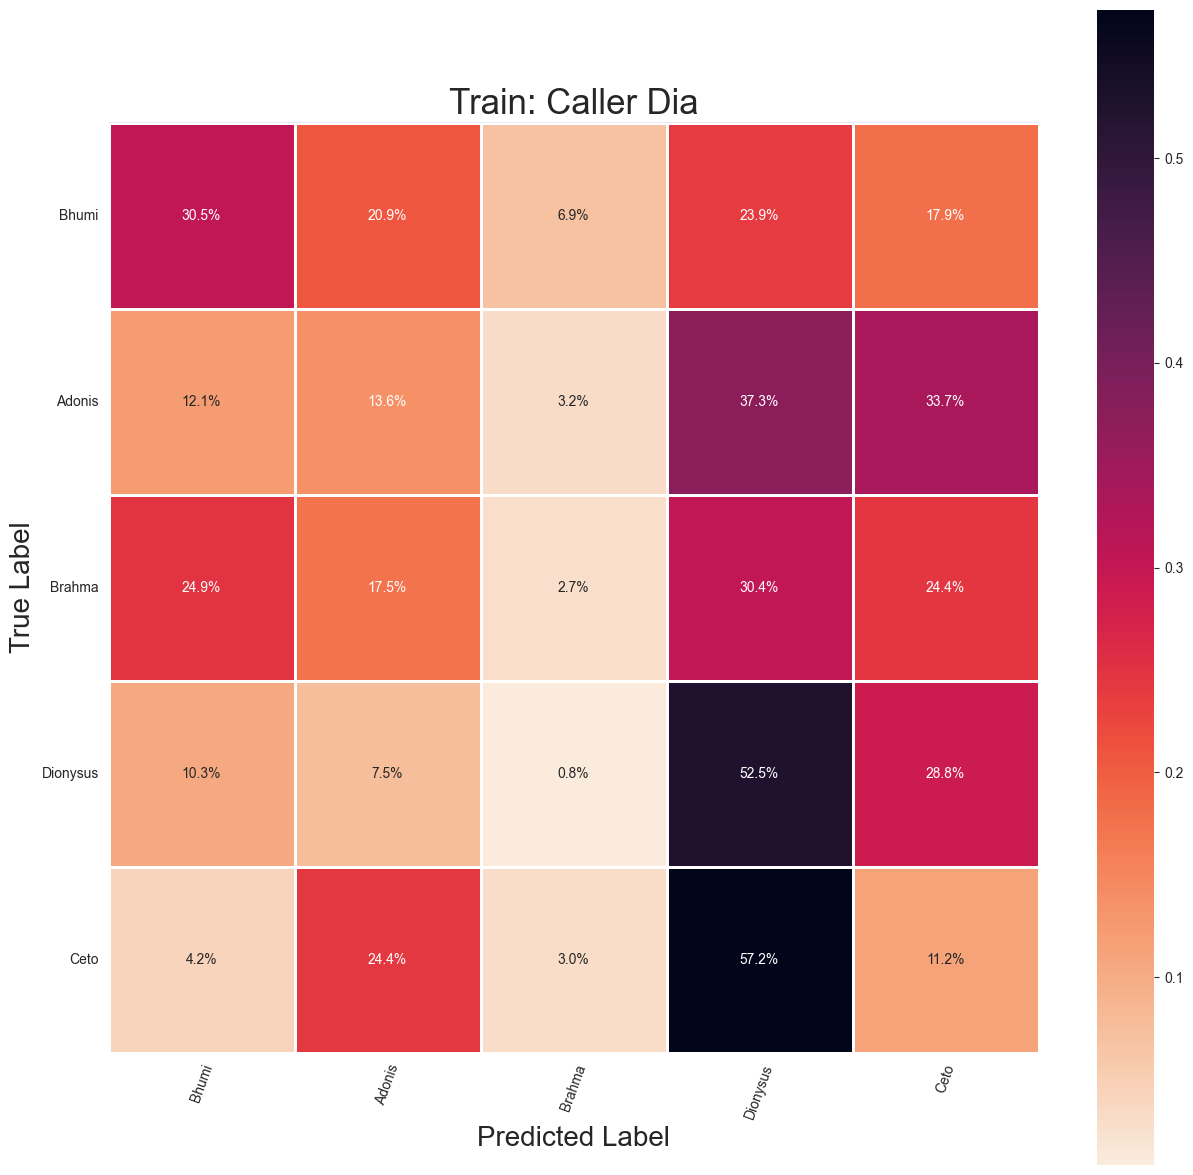

  0%|          | 0/100 [00:00<?, ?it/s]

Train

callee
Adonis    377
Bhumi     377
Ceto      377
Dia       377
Ella      377
dtype: int64


Test

callee
Adonis    316
Bhumi     316
Ceto      316
Dia       316
Ella      316
dtype: int64


100%|██████████| 100/100 [20:52<00:00, 12.53s/it]


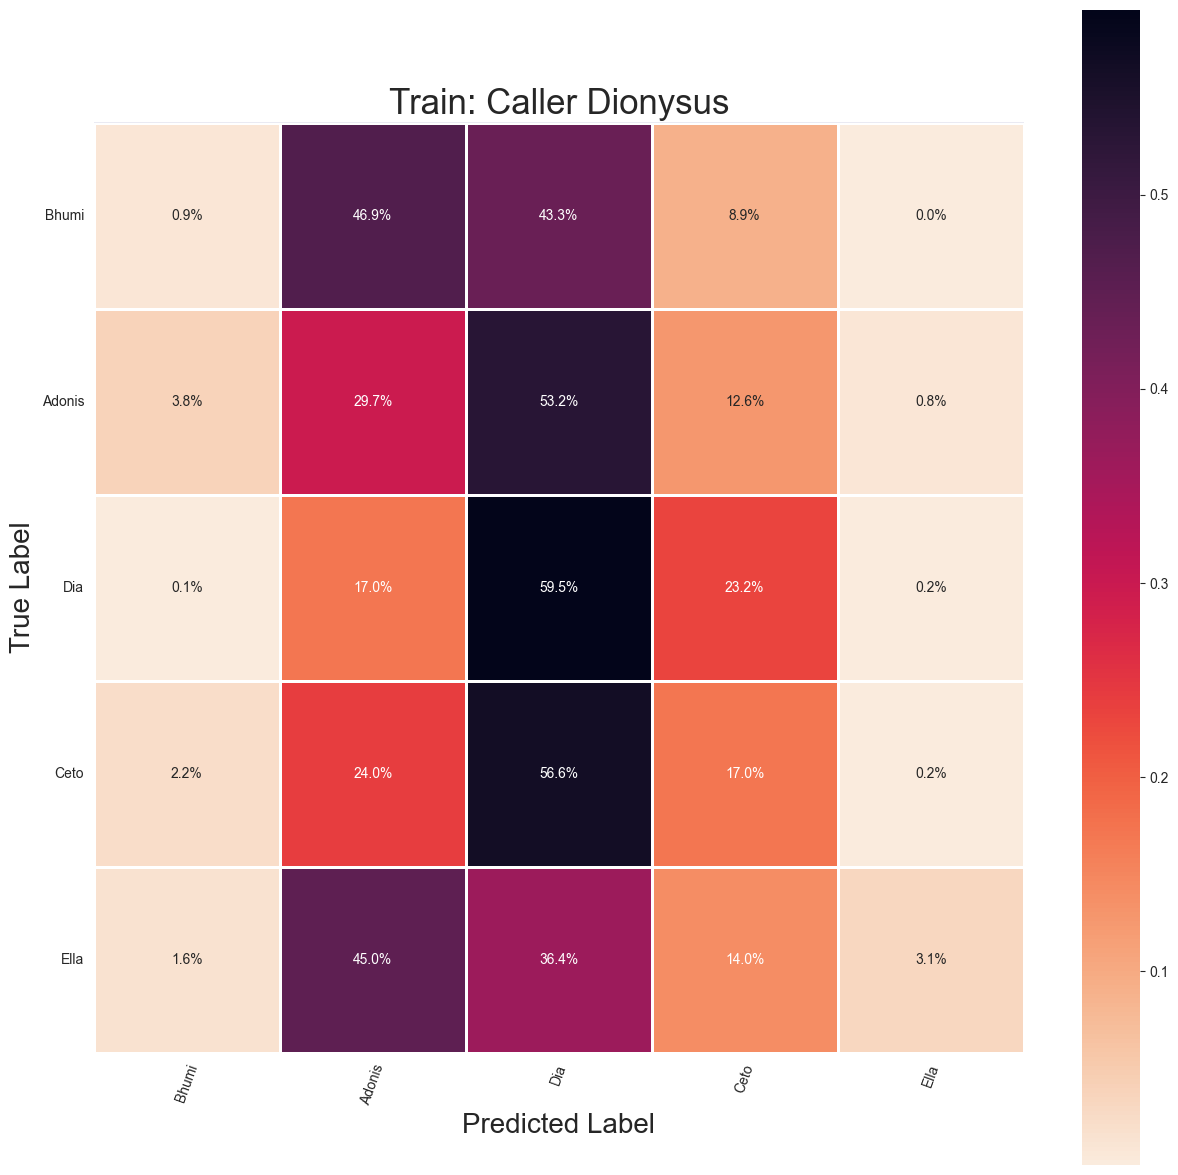

  0%|          | 0/100 [00:00<?, ?it/s]

Train

callee  
Adonis      150
Bhumi       150
Brahma      150
Chaos       150
Dia         150
Dionysus    150
dtype: int64


Test

callee  
Adonis      51
Bhumi       51
Brahma      51
Chaos       51
Dia         51
Dionysus    51
dtype: int64


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


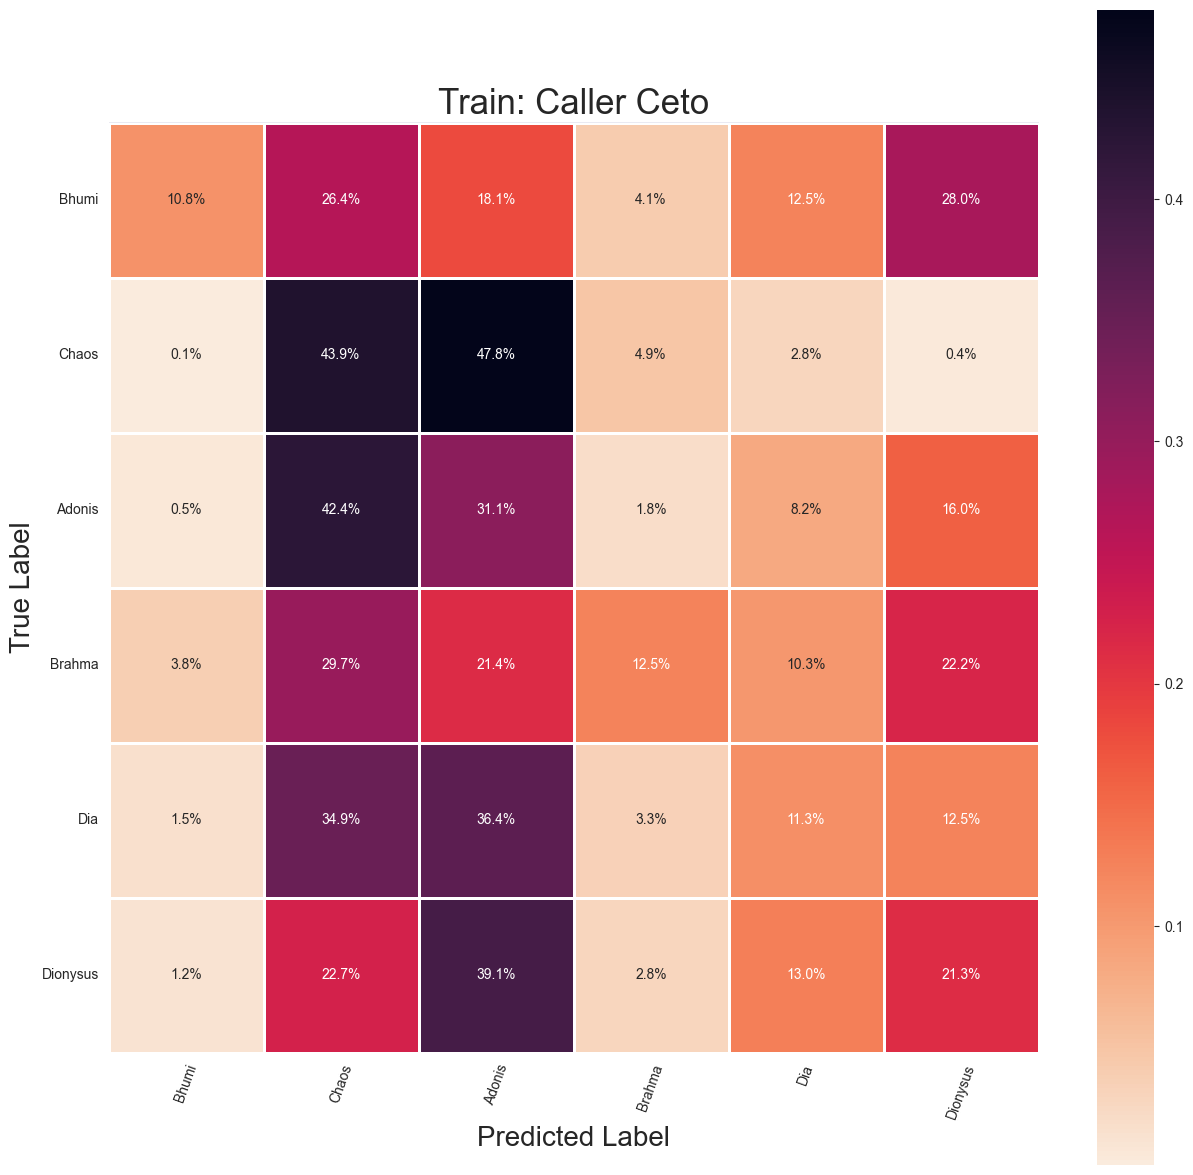

  0%|          | 0/100 [00:00<?, ?it/s]

Train

callee  
Ceto        129
Dia         129
Dionysus    129
Ella        129
dtype: int64


Test

callee  
Ceto        564
Dia         564
Dionysus    564
Ella        564
dtype: int64


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


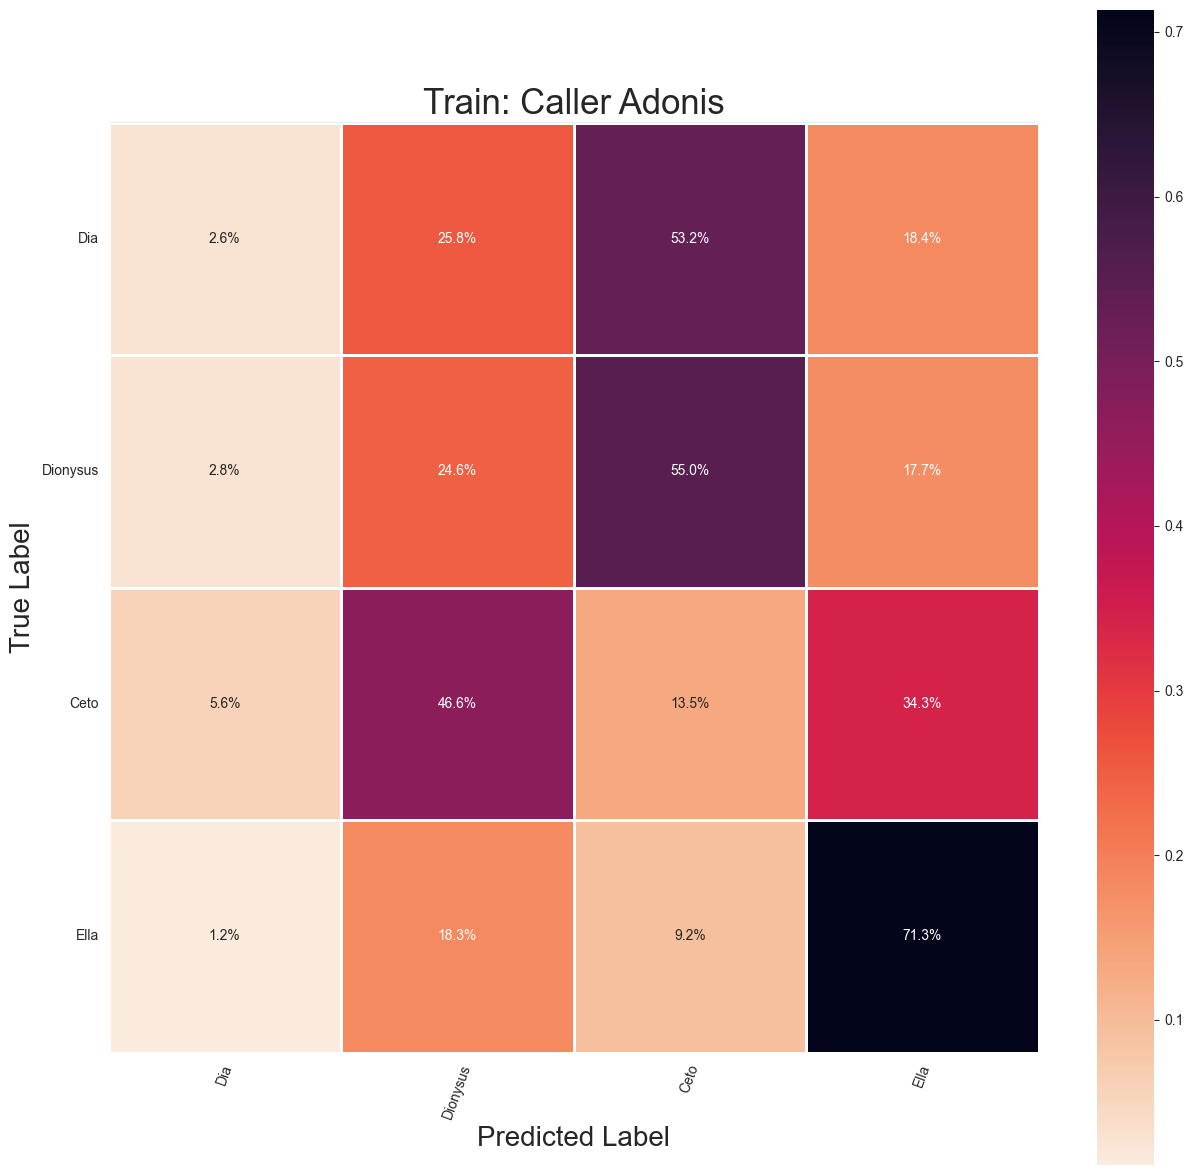

  0%|          | 0/100 [00:00<?, ?it/s]

Train

callee  
Baloo       103
Barak       103
Bareket     103
Bolt        103
Brahma      103
Dia         103
Dionysus    103
Ella        103
dtype: int64


Test

callee  
Baloo       364
Barak       364
Bareket     364
Bolt        364
Brahma      364
Dia         364
Dionysus    364
Ella        364
dtype: int64


100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


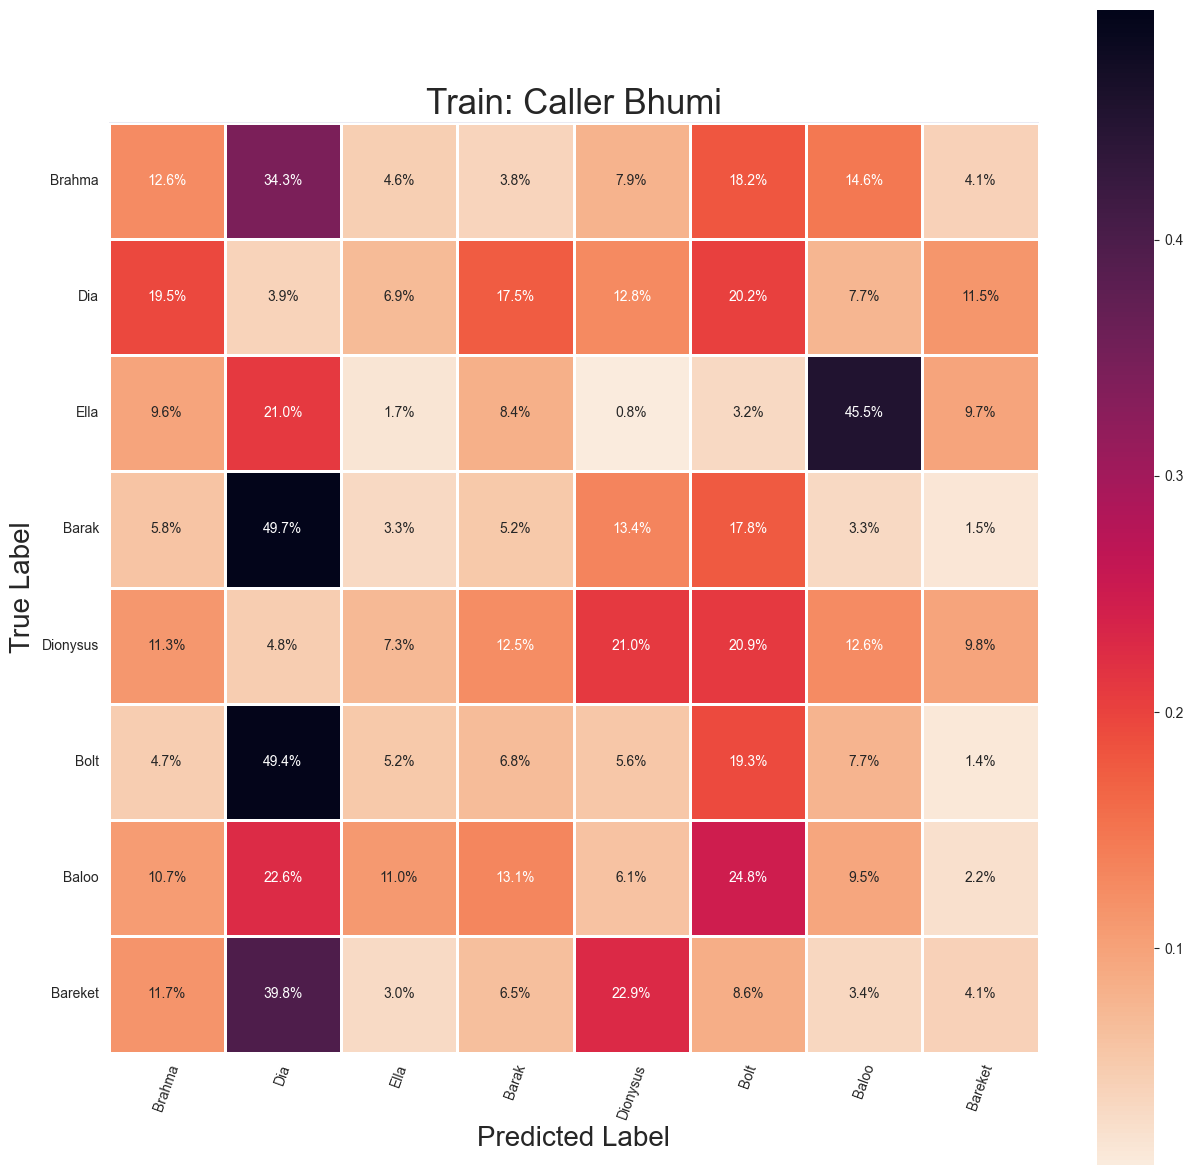

  0%|          | 0/100 [00:00<?, ?it/s]

Train

callee  
Adonis      144
Bhumi       144
Dia         144
Dionysus    144
dtype: int64


Test

callee  
Adonis      4018
Bhumi       4018
Dia         4018
Dionysus    4018
dtype: int64


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


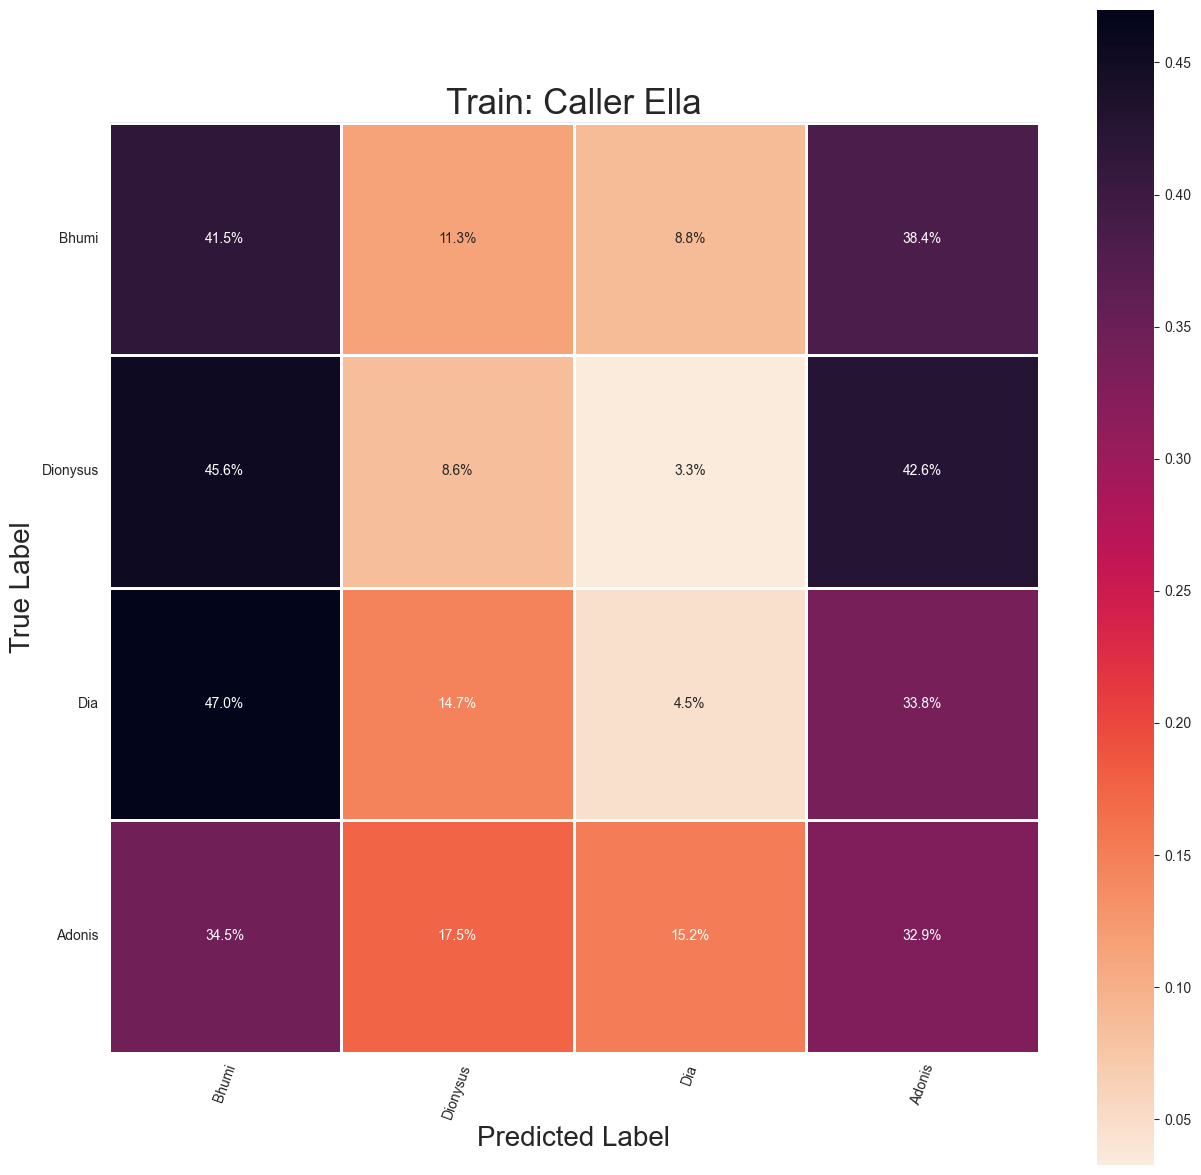

In [14]:
repeat_amount = 100
names = ["Dia", "Dionysus", "Ceto", "Adonis", "Bhumi", "Ella"]
callees_to_drop = [['Ella'], ["Brahma", "Chaos"], [], [], ["Adonis", "Ceto"], []]
rus = RandomUnderSampler()
rfc = RandomForestClassifier()

for drop_callees, name in zip(callees_to_drop, names):
    train = df_flattened.loc[df_flattened["caller"] == name]
    train = train[~train["callee"].isin(drop_callees)]
    test = df_flattened.loc[df_flattened["caller"] != name]

    train_callees, test_callees2 = set(train["callee"].unique()), set(test["callee"].unique())
    common_callees = train_callees.intersection(test_callees2)
    train = train[train['callee'].isin(common_callees)]
    X_train, y_train = train.drop(columns=["caller", "callee", "expname", "expnameid"]), train.filter(items=["callee"])
    test = test[test['callee'].isin(common_callees)]
    X_test, y_test = test.drop(columns=["caller", "callee", "expname", "expnameid"]), test.filter(items=["callee"])

    cm_list = []
    for i in tqdm(range(repeat_amount)):
        X_train, y_train = rus.fit_resample(X_train, y_train)
        X_test, y_test = rus.fit_resample(X_test, y_test)
        if i == 0:
            print_info(y_train, y_test)
        labels = list(common_callees)
        rfc, cmn = fit_and_predict(X_train, y_train, X_test,y_test,labels)
        cm_list.append(cmn)

    show_cm(np.mean(cm_list, axis=0),f"Train: Caller {name}", labels)